3.1. BASELINE на FASTTEXT

In [ ]:
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
from string import punctuation
import pickle
import pandas as pd
import numpy as np
import nltk
import re
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import random
from nltk.corpus import wordnet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/NLP_HW1'

Mounted at /content/drive


In [ ]:
train_data = pd.read_csv(path + '/part_3/hpac_training_128.tsv', sep = '\t', header = None)
test_data = pd.read_csv(path + '/part_3/hpac_test_128.tsv', sep = '\t', header = None)
dev_data = pd.read_csv(path + '/part_3/hpac_dev_128.tsv', sep = '\t', header = None)

FileNotFoundError: ignored

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
train_data[2].iloc[6]

"would he care ? and harry vanished , refusing to admit the purr that seemed to roll through his body when he used his magic that way . draco knew when potter had arrived even before he heard the pounding at the door , because severus 's breathing immediately sounded deeper and stronger , and draco could move further away than the bond would ordinarily permit . draco smoothly and quietly unlocked the door with a spell . he hoped potter would have the sense to come in on his own , and it seemed he did . draco heard someone picking their way through an unfamiliar dark room , a stumble , a curse , and then the soft whispered incantation that potter used to cast a"

Данные все уже в нижнем регистре, но есть пунктуация, наверно стоп слова

In [ ]:
tokenizer = WordPunctTokenizer()
stemmer = PorterStemmer() 

drop = set(stopwords.words('english') + list(punctuation) +list(' ``'))

def clean(text, drop):
  text = re.sub("[^a-zA-Z]", " ", text) #это чтобы кавычки не попали например
  
  words = word_tokenize(text.lower()) #да чет стремно стало, а вдруг большие буквы остались
  words =[stemmer.stem(word) for word in words]
 
  for word in words:
     words.remove(word) if word in drop else words 
 
  words=" ".join(words).strip()
  return words

In [ ]:
#Как читал Скрип: "Барыги тоже не видали этот чистый"

train_clean = train_data.copy()
test_clean = test_data.copy()
dev_clean = dev_data.copy()

train_clean[2] = train_clean[2].apply(lambda i: clean(i, drop)) 

test_clean[2] = test_clean[2].apply(lambda i:clean(i, drop)) 

dev_clean[2] = dev_clean[2].apply(lambda i: clean(i, drop))

In [ ]:
train_clean

,0,1,2
0,7642954.0.676,RIDDIKULUS,stare wa next face boggart defens dark art cla...
1,10443333.0.5753,RIDDIKULUS,whole time first reaction felt quit proud sinc...
2,4703706.0.8690,STUPEFY,watch hi inglori withdraw togeth accompani phi...
3,4593427.0.1815,ACCIO,wand incendio thi wretch chilli weather get ne...
4,4278446.0.2692,EXPELLIARMUS,alreadi compar they everyday al give your let ...
...,...,...,...
60975,2790536.0.136,CRUCIO,evenli match good evil light dark white black ...
60976,7553216.0.1500,ACCIO,professor turn walk open appear behind gargoyl...
60977,2721339.0.1040,DIFFINDO,ran crowd felt eye well with tear horribl thi ...
60978,2569402.0.4724,INCENDIO,ministri decad ago record hi thought spell wa ...


In [ ]:
with open(path + '/part_3/data_train.txt', 'w+') as train_file:
    for i in range(len(train_clean)):
        text = train_clean.iloc[i][2]
        target = train_clean.iloc[i][1]
        train_file.write('__label__' + target + ' '+ text + '\n')

with open(path + '/part_3/data_dev.txt', 'w+') as dev_file:
    for i in range(len(dev_clean)):
        text = dev_clean.iloc[i][2]
        target = dev_clean.iloc[i][1]
        dev_file.write('__label__' + target + ' '+ text + '\n')

with open(path + '/part_3/data_test.txt', 'w+') as test_file:
    for i in range(len(test_clean)):
        text = test_clean.iloc[i][2]
        target = test_clean.iloc[i][1]
        test_file.write('__label__' + target + ' '+ text + '\n')

In [ ]:
#! git clone https://github.com/facebookresearch/fastText.git
#! pip3 install fastText/.

In [ ]:
import fasttext

classifier = fasttext.train_supervised(input=path + '/part_3/data_train.txt', autotuneValidationFile=path + '/part_3/data_dev.txt', loss='ova', autotuneMetric="f1")

In [ ]:
target_list =[]
pred_list =[]

for i in range(len(test_clean)):
      target_list.append('__label__' +test_clean.iloc[i][1])
      pred_list.append(classifier.predict(test_clean.iloc[i][2])[0][0])

In [ ]:
1 /len(train_clean[1].unique()) #вероятность случайно попасть если классы сбалансированы

0.011764705882352941

In [ ]:
from sklearn.metrics import  f1_score
print('f1-micro: ', f1_score(target_list, pred_list, average='micro'))
print('f1-macro: ', f1_score(target_list, pred_list, average='macro'))

f1-micro:  0.31358249772105745
f1-macro:  0.07643491546450121


В общих чертах прогноз казался не самым плохим, но при усреднении ф-меры по лэйблам без взвешивания по количеству объектов точность кажется ниже, чем у случайного угадывания...

In [ ]:
from sklearn.metrics import classification_report,  precision_score, recall_score
print(classification_report(target_list, pred_list))

                              precision    recall  f1-score   support

              __label__ACCIO       0.24      0.42      0.31       516
          __label__AGUAMENTI       0.17      0.09      0.12        79
          __label__ALOHOMORA       0.36      0.39      0.37       164
            __label__ANAPNEO       0.00      0.00      0.00         4
          __label__APARECIUM       0.00      0.00      0.00         9
      __label__AVADA_KEDAVRA       0.35      0.56      0.43       915
               __label__AVIS       0.00      0.00      0.00        27
      __label__CAVE_INIMICUM       0.00      0.00      0.00         2
        __label__COLLOPORTUS       0.00      0.00      0.00        39
          __label__CONFRINGO       0.00      0.00      0.00        43
           __label__CONFUNDO       0.00      0.00      0.00        17
             __label__CRUCIO       0.36      0.58      0.44       909
            __label__DEFODIO       0.00      0.00      0.00         6
          __label__

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Не попадаем по малоупомянутым заклинаниям. Из явных исключений риддикулус - единственное с относительно высокой ф-мерой при упоминании менее ста раз в тесте. Насколько помню заклинание использовалось только или почти только, когда Люмус учил бороться с Дементорами, что могло упростить задачу угадывания.

In [ ]:
target_list =[]
pred_list =[]

for i in range(len(test_clean)):
      target_list.append('__label__' +train_clean.iloc[i][1])
      pred_list.append(classifier.predict(train_clean.iloc[i][2])[0][0])

In [ ]:
print('f1-micro: ', f1_score(target_list, pred_list, average='micro'))
print('f1-macro: ', f1_score(target_list, pred_list, average='macro'))

f1-micro:  0.44458913921083476
f1-macro:  0.11649480352410972


In [ ]:
print(classification_report(target_list, pred_list))

                              precision    recall  f1-score   support

              __label__ACCIO       0.40      0.68      0.50       510
          __label__AGUAMENTI       0.53      0.21      0.30       116
          __label__ALOHOMORA       0.54      0.63      0.58       157
            __label__ANAPNEO       0.00      0.00      0.00         5
          __label__APARECIUM       0.00      0.00      0.00        11
      __label__AVADA_KEDAVRA       0.47      0.71      0.56       950
               __label__AVIS       0.00      0.00      0.00        16
      __label__CAVE_INIMICUM       0.00      0.00      0.00         3
        __label__COLLOPORTUS       0.00      0.00      0.00        25
          __label__CONFRINGO       0.00      0.00      0.00        35
           __label__CONFUNDO       0.00      0.00      0.00        10
             __label__CRUCIO       0.45      0.74      0.56       899
            __label__DEFODIO       0.00      0.00      0.00         3
          __label__

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Повторили то же самое с трэином. Заметим, что риддикулус не упоминается там чаще - возможно гипотеза верна.

Вывод:

1. Количество упоминаний заклинания положительно сказываются на качестве прогноза (логично, больше обучаемся, в целом угадать проще). Из тех, что упоминались менее 100 раз превысили Ф-меру = 0.1 на тесте только Риддикулус(превращает страшное в смешное), Муфлиато(вызывает шум в ушах, чары Снейппа, возможно популярно в фанфиках?), то есть достаточно специфичные и эпизодичные штуки. Тем не менее из редких хорошо показала себя только Риддикулус (герой одного эпизода) - 0.72.
Возможно важно не только количество, но и что-то вроде плотности? концентрации?

2. Хорошо показали себя заклинания Авада Кедавра и Крушио ,вероятно, в силу своей популярности - 950 и 899 на трэине, 915 и 909 на тесте (самые частые упоминания). По 0.43 и 0.44 Ф1

3. Также достойны упоминания: Патронум, Люмус и Легилименция - 0.53, 0.42, 0.42 Ф-мера. Думаю, при меньшем упоминании результаты не хуже чем у Авады Кедавры и Крушио из-за большей привязки к контексту заклинаний - то есть первые 2 используют злодеи в бою в целом, а патронум в основном против дементоров + тренировка в отряде Дамболдора,Люмус - дает свет, а Легилименция - чтение мыслей.

То есть мы в явном виде можем заметить 2 фактора успеха - количество упоминаний и специфика контекста.

Тем не менее, в общем прогноз не очень качественный - в среднем по ф-мерам лэйблов хуже, чем случайное гадание по сбалансированной выборке.

3.3.Повысим качество с помощью аугментации

Реализация на фасттексте

Text(0.5, 1.0, 'Percentage of each spell in the total number of spells')

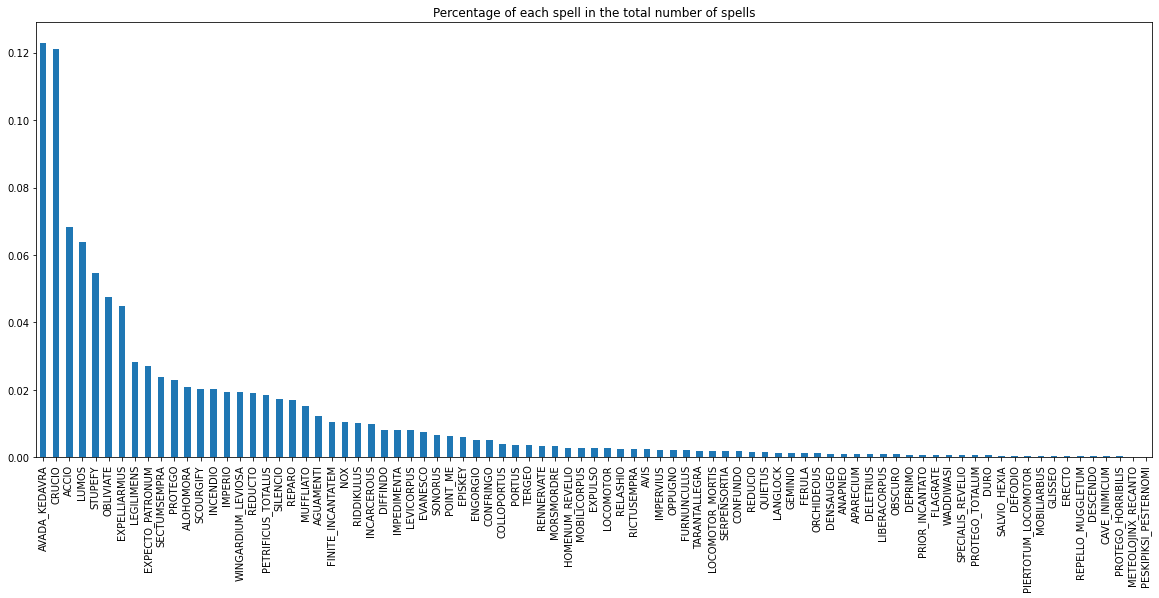

In [ ]:
import matplotlib.pyplot as plt
train_clean[1].value_counts(normalize = True).sort_values(ascending=False).plot(kind = 'bar', figsize=(20,8))
plt.title('Percentage of each spell in the total number of spells')

Text(0.5, 1.0, 'Number of spells')

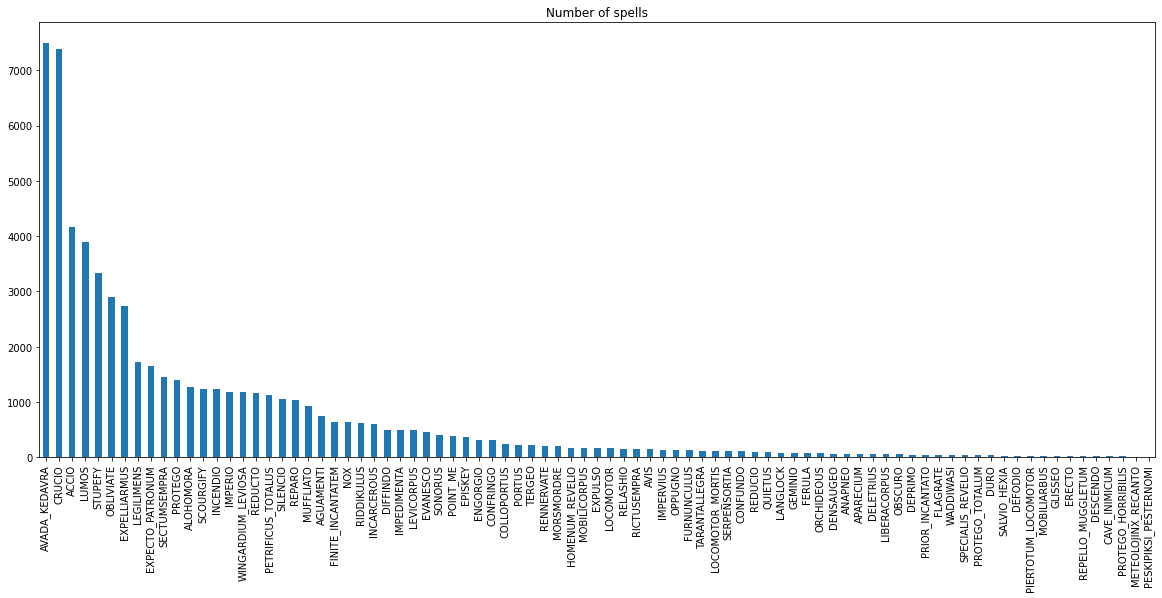

In [ ]:
train_clean[1].value_counts().sort_values(ascending=False).plot(kind = 'bar', figsize=(20,8))
plt.title('Number of spells')

Как можем заметить, на лицо страшная разбалансировка и данных по некоторым классам почти нет

Функции взяты из интернета, открытый источник. 
Наименование статьи и ссылку прикрепляю: 

Статья: Data Augmentation in Natural Language Processing


Ссылка: https://maelfabien.github.io/machinelearning/NLP_8/#synonym-replacement-sr

In [ ]:
def get_synonyms(word):

    synonyms = set()
    
    for syn in wordnet.synsets(word): 
        for l in syn.lemmas(): 
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)


def synonym_replacement(words, n):
    
    words = words.split()
    try:
      words_to_replace = random.sample(words, n)
    except: 
      if len(words) >1:
        n = 1
        words_to_replace = random.sample(words, n)
      elif len(words) == 1:
        words_to_replace = words
      else:
        sentence = ' '.join(map(str, words))
        print('except in replacing. 0 words in text')
        return sentence
    for word in words_to_replace:
        synonyms = get_synonyms(word)
        
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            words = [synonym if word_1 == word else word_1 for word_1 in words]
           
    #print(new_words)

    sentence = ' '.join(map(str, words))

    return sentence

def add_synonym(words, n, m):
    words = words.split()
    if len(words) > n:
      words_to_replace = random.sample(words, n)
    else:
      sentence = ' '.join(map(str, words))

      return sentence
  
      
    for word in words_to_replace:
        synonyms = get_synonyms(word)
        
        if len(synonyms) >= 1:
          try:
            synonym = random.sample(list(synonyms), m)
            words += list(synonym)
          except:
            words += list(synonyms)
            print('except in adding')
           
    #print(new_words)

    sentence = ' '.join(map(str, words))

    return sentence
  
def random_del(words, p):

    words = words.split()

    
    for word in words:
      if len(words) == 1:
        break
      else:
        r = random.uniform(0, 1)
        if r < p:
            words.remove(word)
    
    sentence = ' '.join(map(str, words))

    return sentence
  

def augment_data(sentence):
  w = random.choice([1,2,3])
  if w == 1: 
    sentence_edited = synonym_replacement(sentence, n = 3)
  elif w == 2: 
    sentence_edited = random_del(sentence, p = 0.3)
  else: 
    sentence_edited = add_synonym(sentence, n =7, m = 1)
  return sentence_edited

Попробуем выбрать рандомно часть данных, и случайно применить к каждому отобранных текстов одну из 3 функций: удалить слова с вероятнотью р, заменить n слов на синонимы, добавить m синонимов для n слов. 

In [ ]:
aug = train_clean.sample(30000, random_state = 1)

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

aug[2] = aug[2].apply(lambda x: augment_data(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


except in replacing. 0 words in text
except in replacing. 0 words in text
except in replacing. 0 words in text
except in replacing. 0 words in text
except in replacing. 0 words in text
except in replacing. 0 words in text
except in replacing. 0 words in text
except in replacing. 0 words in text
except in replacing. 0 words in text
except in replacing. 0 words in text
except in replacing. 0 words in text
except in replacing. 0 words in text
except in replacing. 0 words in text
except in replacing. 0 words in text
except in replacing. 0 words in text
except in replacing. 0 words in text
except in replacing. 0 words in text
except in replacing. 0 words in text
except in replacing. 0 words in text


In [ ]:
df_train_augmented = pd.concat([train_clean, aug]).sample(frac=1).reset_index(drop=True)

In [ ]:
len(df_train_augmented)

90980

In [ ]:
len(train_clean)

60980

Text(0.5, 1.0, 'Number of spells')

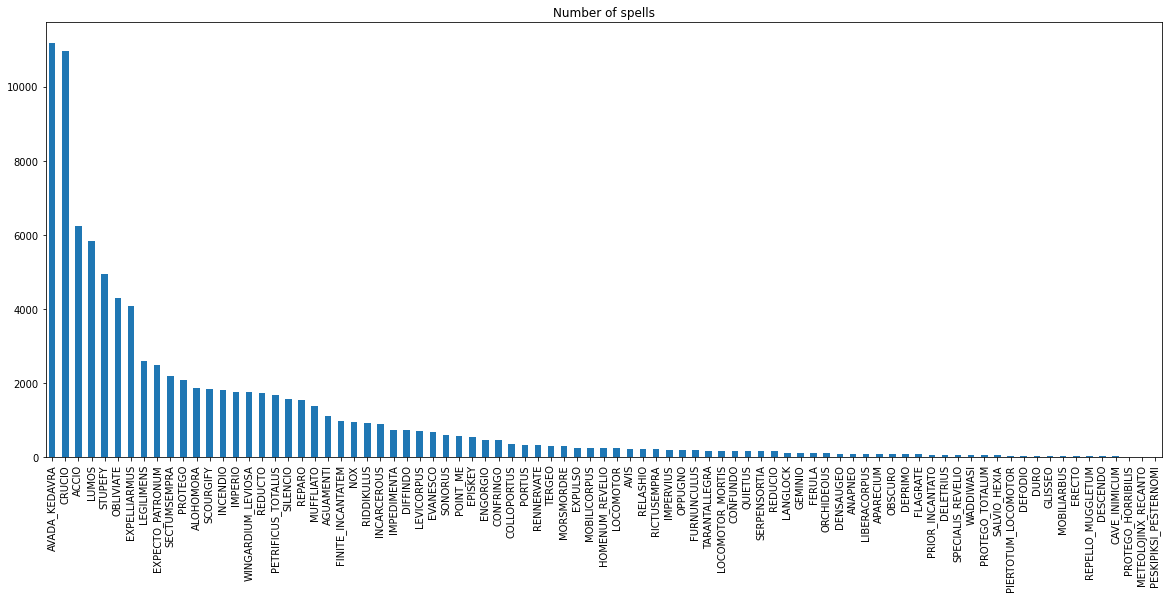

In [ ]:
df_train_augmented[1].value_counts().sort_values(ascending=False).plot(kind = 'bar', figsize=(20,8))
plt.title('Number of spells')

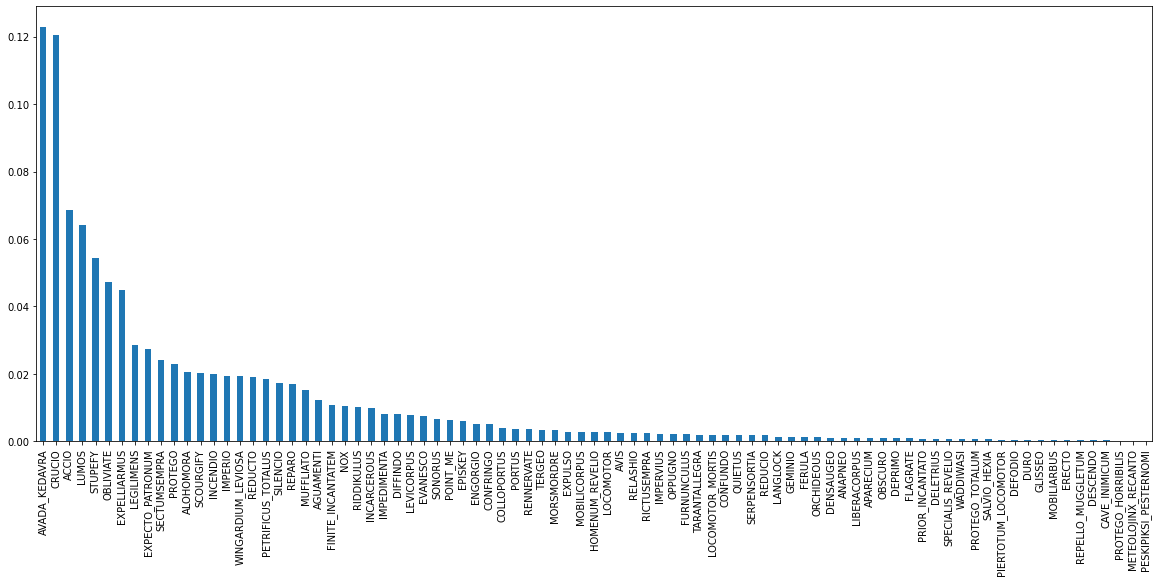

In [ ]:
df_train_augmented[1].value_counts(normalize = True).sort_values(ascending=False).plot(kind = 'bar', figsize=(20,8))

Баланс классов +- сохранился, но количество данных увеличили в 1.5 раза

In [ ]:
with open(path + '/part_3/data_train_aug_1.txt', 'w+') as train_file:
    for i in range(len(train_clean)):
        text = df_train_augmented.iloc[i][2]
        target = df_train_augmented.iloc[i][1]
        train_file.write('__label__' + target + ' '+ text + '\n')

In [ ]:
classifier = fasttext.train_supervised(input=path + '/part_3/data_train_aug_1.txt', autotuneValidationFile=path + '/part_3/data_dev.txt', loss='ova', autotuneMetric="f1")

In [ ]:
target_list =[]
pred_list =[]

for i in range(len(test_clean)):
      target_list.append('__label__' +test_clean.iloc[i][1])
      pred_list.append(classifier.predict(test_clean.iloc[i][2])[0][0])

In [ ]:
from sklearn.metrics import  f1_score
print('f1-micro: ', f1_score(target_list, pred_list, average='micro'))
print('f1-macro: ', f1_score(target_list, pred_list, average='macro'))

f1-micro:  0.2973043365021487
f1-macro:  0.0754578078328165


Хуже чем до аугментации....

Ладно, тогда возьмем те заклинания, которых у нас меньше 1000, и размножим их

In [ ]:
a =train_clean[1].value_counts()[train_clean[1].value_counts()<900].index.values

In [ ]:
aug_1 = train_clean[train_clean[1].isin(a)]
aug_2 = train_clean[train_clean[1].isin(a)]
aug_3 = train_clean[train_clean[1].isin(a)]

Сделаем для каждого случая по 3 варианта, применив каждую из функций

In [ ]:
aug_1[2] = aug_1[2].apply(lambda x: synonym_replacement(x, 3))
aug_2[2] = aug_2[2].apply(lambda x: random_del(x, 0.5))
aug_3[2] = aug_3[2].apply(lambda x: add_synonym(x, 7, 1))

except in replacing. 0 words in text
except in replacing. 0 words in text
except in replacing. 0 words in text
except in replacing. 0 words in text
except in replacing. 0 words in text
except in replacing. 0 words in text
except in replacing. 0 words in text
except in replacing. 0 words in text


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
df_train_augmented_2 = pd.concat([train_clean, aug_1, aug_2, aug_3]).sample(frac=1).reset_index(drop=True)

In [ ]:
len(df_train_augmented_2)

95351

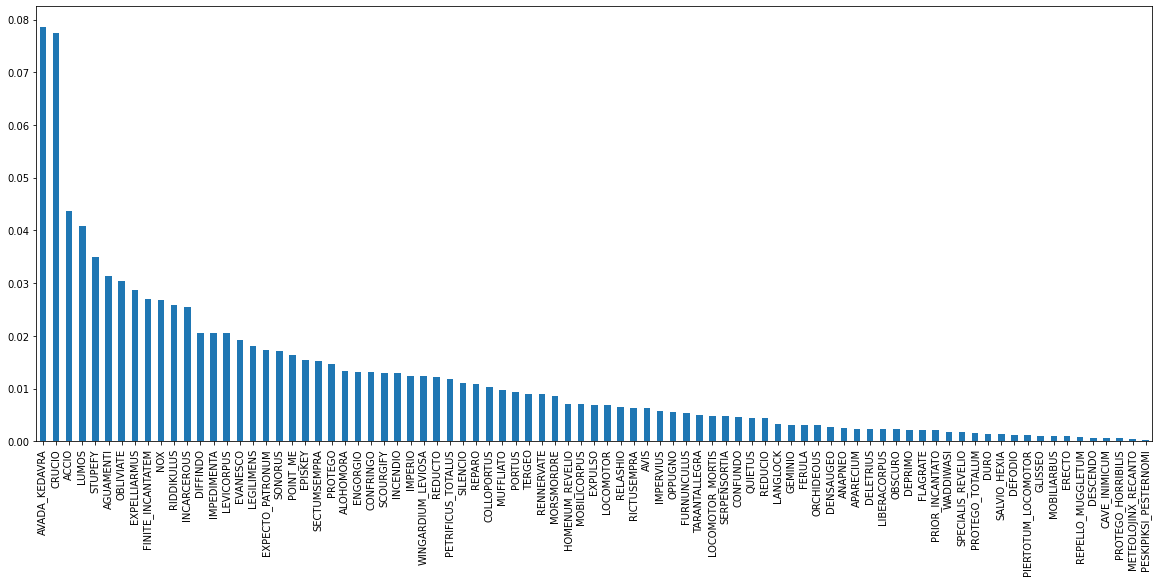

In [ ]:
df_train_augmented_2[1].value_counts(normalize = True).sort_values(ascending=False).plot(kind = 'bar', figsize=(20,8))

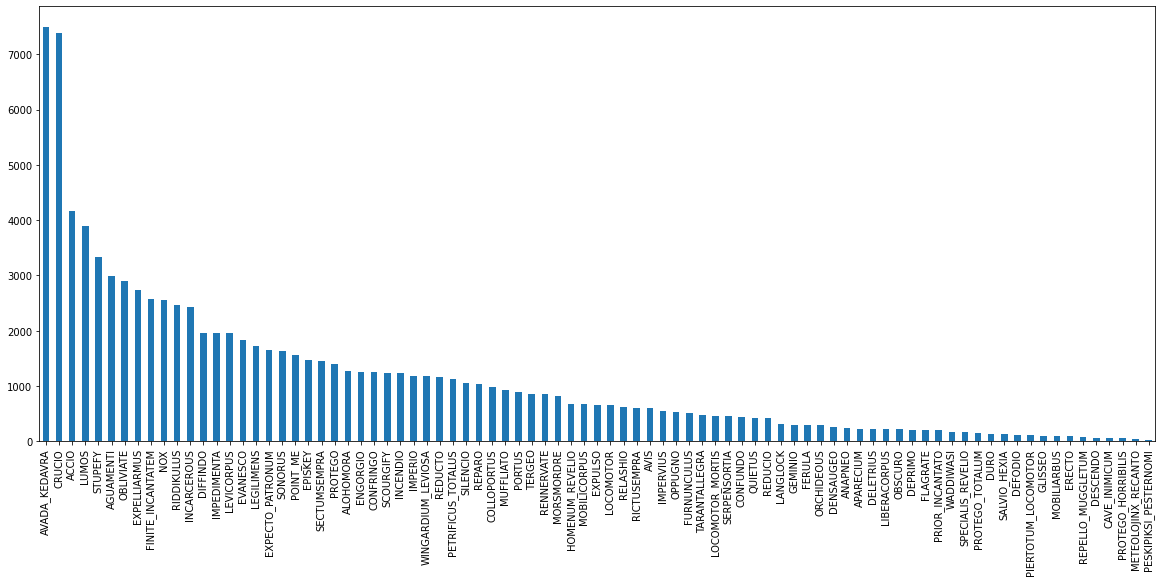

In [ ]:
df_train_augmented_2[1].value_counts().sort_values(ascending=False).plot(kind = 'bar', figsize=(20,8))

Поменяли баланс классов, а количество попсовых заклинаний не поменяли

In [ ]:
with open(path + '/part_3/data_train_aug_2.txt', 'w+') as train_file:
    for i in range(len(train_clean)):
        text = df_train_augmented_2.iloc[i][2]
        target = df_train_augmented_2.iloc[i][1]
        train_file.write('__label__' + target + ' '+ text + '\n')

In [ ]:
classifier = fasttext.train_supervised(input=path + '/part_3/data_train_aug_2.txt', autotuneValidationFile=path + '/part_3/data_dev.txt', loss='ova', autotuneMetric="f1")

In [ ]:
target_list =[]
pred_list =[]

for i in range(len(test_clean)):
      target_list.append('__label__' +test_clean.iloc[i][1])
      pred_list.append(classifier.predict(test_clean.iloc[i][2])[0][0])

In [ ]:
from sklearn.metrics import  f1_score
print('f1-micro: ', f1_score(target_list, pred_list, average='micro'))
print('f1-macro: ', f1_score(target_list, pred_list, average='macro'))

f1-micro:  0.2868863133220471
f1-macro:  0.10536115972173153


По итогу макро ф1 выросло на 38%, но микро сократилось.